# 1. Introduction

## Cardiovascular Disease Risk Prediction

This project uses a cardiovascular dataset of 70,000 patients to explore risk factors and build a predictive model for cardiovascular disease (CVD).

**Goals:**
- Clean and preprocess the dataset.
- Explore relationships between BMI, blood pressure, cholesterol, glucose, and CVD.
- Engineer medically meaningful features (e.g. BMI categories, blood pressure stages).
- Train a classification model to predict CVD.

**Tools:** Python (Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn)


# 2. Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import statsmodels

In [2]:
from utils.plotting import plot_hist, plot_bar, barh_percent, plot_boxes, plot_subplots, plot_stacked_counts, plot_heatmap_table
from utils.evaluation import train_binary_classifier, make_logreg_pipeline
from utils.chategorize import categorize_bp

In [3]:
import config

In [4]:
config.DATASET_NAME.parent / "train.csv"

PosixPath('/Users/lizarabkina/PythonProjects/Cardio/data/train.csv')

In [5]:
df = pd.read_csv(config.DATASET_NAME, sep=";")

In [6]:
original_df = df.copy()
original_df.shape

(70000, 13)

In [7]:
df = original_df.copy() # working df


# 3. Dataset Overview


#### 3.1 Dataset Description

In [8]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [9]:
df.shape,df.columns
print(f"There are total of {df.shape[0]} datapoints in this dataset with {(df.shape[1])} columns:")
print(", ".join(df.columns))

There are total of 70000 datapoints in this dataset with 13 columns:
id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio


#### 3.2 Feature Description

| Feature        | Description |
|----------------|-------------|
| **age**        | Age of the patient in days *(convert to years)* |
| **gender**     | 1 = female, 2 = male |
| **height**     | Height in centimeters |
| **weight**     | Weight in kilograms |
| **ap_hi**      | Systolic blood pressure |
| **ap_lo**      | Diastolic blood pressure |
| **cholesterol**| 1 = normal, 2 = above normal, 3 = well above normal |
| **gluc**       | 1 = normal, 2 = above normal, 3 = well above normal |
| **smoke**      | Binary lifestyle feature (0 = no, 1 = yes) |
| **alco**       | Binary lifestyle feature (0 = no, 1 = yes) |
| **active**     | Physical activity (0 = no, 1 = yes) |
| **cardio**     | **Target:** Cardiovascular disease (1 = yes, 0 = no) |


#### 3.3 Checking datatypes

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


#### 3.4 Basic Statistics

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


#### 3.5 Handle missing values
In this step, I check for missing values and decide how to treat them.

In [12]:
print("Missing values:\n",df.isnull().sum())

Missing values:
 id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


- No missing values are observed, therefore we continue to the next step of analysis.

#### 3.6 Columns removal

In this section I removed "id" column since it didn't bring any value for the analysis

In [13]:
df = df.drop(columns=['id'])

#### 3.7 Handling duplicates

In [14]:
print(f"Dataset contains {df.duplicated().sum()} duplicates.")

Dataset contains 24 duplicates.


In [15]:

duplicated = df[df.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
1142,17493,2,169,74.0,120,80,1,1,0,0,1,1
50432,17493,2,169,74.0,120,80,1,1,0,0,1,1
32683,17535,2,165,65.0,120,80,1,1,0,0,1,0


In [16]:
df.drop_duplicates(keep="first", inplace =True)
print(f"After removal of duplicates total of {df.shape[0]} rows and {df.shape[1]} columns remained.")

After removal of duplicates total of 69976 rows and 12 columns remained.


#### 3.8 Target balance

In [17]:
print("Target groups (absolute values):",df["cardio"].value_counts())
print("_______________________________")
print("Target groups (%):",df["cardio"].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

Target groups (absolute values): cardio
0    35004
1    34972
Name: count, dtype: int64
_______________________________
Target groups (%): cardio
0    50.02%
1    49.98%
Name: proportion, dtype: object


- The dataset is equally balanced

# 4. Data cleaning
In this section I clean the raw dataset by:

- converting age from days to years
- handling unrealistic height, weight, and blood pressure values
- removing obvious outliers
- preparing a clean DataFrame (`df_clean`) for further analysis


In [18]:
df_clean = df.copy()

#### 4.1 Convert age and create BMI

In [19]:
# 1. Convert age in days to years
df_clean["age_years"]= df_clean["age"] / 365.25
# 2. Calculate BMI
df_clean["bmi"] = (df_clean["weight"] / (df_clean["height"]/100)**2).round(1)



#### 4.2 Outliers exploratory analysis 

In [20]:
num_cols = df_clean.select_dtypes(include=np.number).columns

summary_table_ = df_clean[num_cols].agg(['min', 'max']).T.round(0)
summary_table_

,min,max
age,10798.0,23713.0
gender,1.0,2.0
height,55.0,250.0
weight,10.0,200.0
ap_hi,-150.0,16020.0
ap_lo,-70.0,11000.0
cholesterol,1.0,3.0
gluc,1.0,3.0
smoke,0.0,1.0
alco,0.0,1.0


- Height: remove unrealistic height (the lowest 55 cm) 
- Weight: remove unrealistic weight (the lowest 10 kg)
- ap_hi,ap_lo: can't be negative


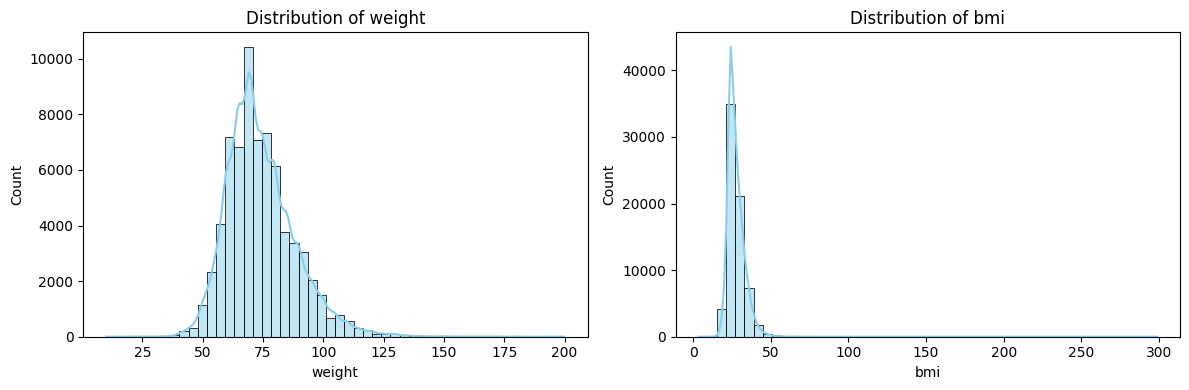

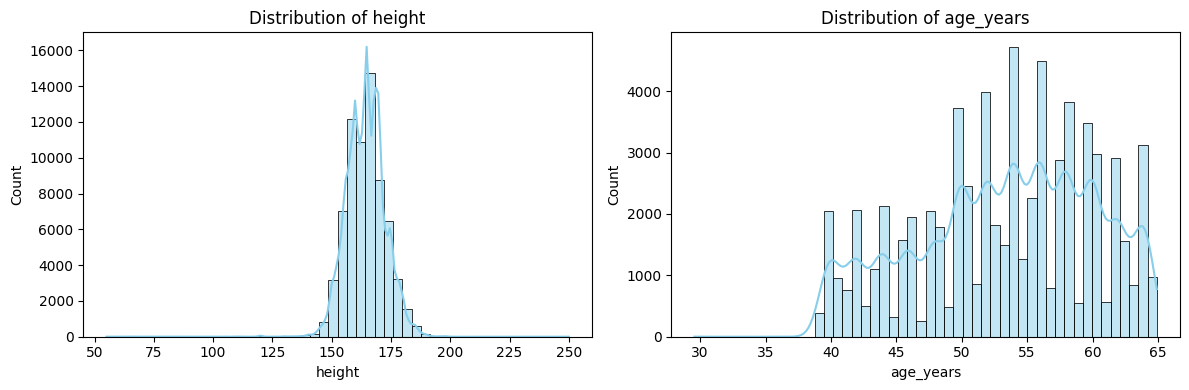

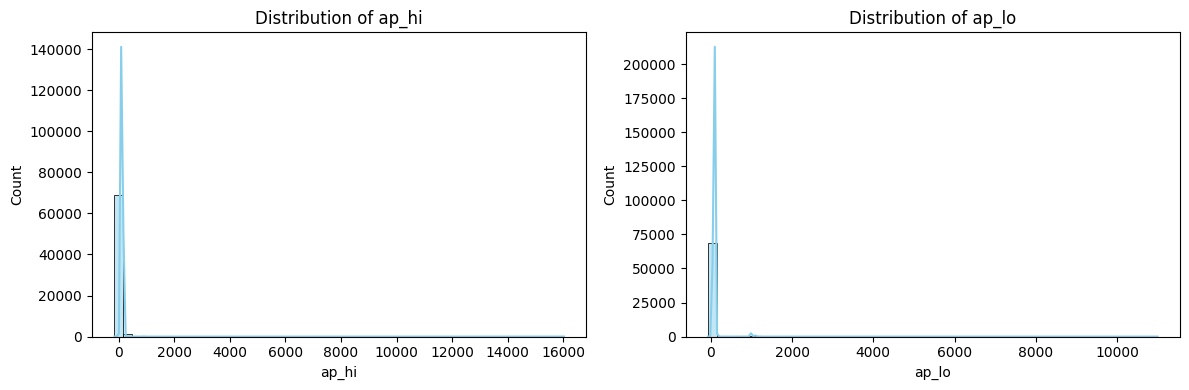

In [21]:
bmi_weight_before = plot_hist(df_clean,["weight","bmi"])
height_age_before = plot_hist(df_clean,["height","age_years"])
ap_hi_lo_before = plot_hist(df,["ap_hi","ap_lo"])

BMI Cut off

In [22]:
# remove BMI <12
pd.set_option('display.max_rows', None)
df_clean[df_clean["bmi"]<12].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
18559,18140,1,160,30.0,120,80,1,1,0,0,1,1,49.664613,11.7
16906,17272,2,170,31.0,150,90,2,2,0,0,1,1,47.288159,10.7
60699,18875,1,171,29.0,110,70,2,1,0,0,1,1,51.676934,9.9
26806,23284,1,157,23.0,110,80,1,1,0,0,1,0,63.748118,9.3
60188,21855,1,162,21.0,120,80,2,1,0,0,1,1,59.835729,8.0


In [23]:
# remove BMI>60
df_clean[df_clean["bmi"]>60].sort_values(by = "bmi",ascending=False).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,53.645448,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,41.867214,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64.027379,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52.221766,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52.260096,191.7


Height and Age cut off

In [24]:
# remove height <140cm
df_clean[df_clean["height"]<140].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,53.645448,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,41.867214,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64.027379,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52.221766,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52.260096,191.7


Blood pressure values (ap_hi/ap_lo) cut off

In [25]:
# convert ap_hi and ap_lo to floats
df_clean["ap_hi"] = df_clean["ap_hi"].astype(float)
df_clean["ap_lo"] = df_clean["ap_lo"].astype(float)

# Fix extreme types like 1000,1401,etc
df_clean.loc[df_clean["ap_hi"] > 250, "ap_hi"] /= 10
df_clean.loc[df_clean["ap_lo"] > 200, "ap_lo"] /= 10

#Fix reversed values (if diastolic > systolic)
swap_mask = df_clean["ap_lo"] > df_clean["ap_hi"]
df_clean.loc[swap_mask, ["ap_hi", "ap_lo"]] = \
    df_clean.loc[swap_mask, ["ap_lo", "ap_hi"]].to_numpy()



#### 4.3 Outliers removal


In [26]:
# Everything is " True"
mask = pd.Series(True, index=df_clean.index)

# 1. Height & BMI filters 
if "height" in df_clean.columns:
    mask &= df_clean["height"].between(140, 200)

if "bmi" in df_clean.columns:
    mask &= df_clean["bmi"].between(12, 60)

# 2. Age filter 
if "age_years" in df_clean.columns:
    mask &= df_clean["age_years"].between(18, 90)

# 3. Blood pressure filters
mask &= df_clean["ap_hi"].between(80, 250)
mask &= df_clean["ap_lo"].between(40, 150)
mask &= df_clean["ap_hi"] >= df_clean["ap_lo"] + 5
mask &= df_clean["ap_hi"] > 0
mask &= df_clean["ap_lo"] > 0

# 4. Weight filters
if "weight" in df_clean.columns:
    mask &= df_clean["weight"].between(40, 200)

# 4. Apply all filters at once
df_clean = df_clean[mask].copy()

df_clean["ap_hi"] = df_clean["ap_hi"].round().astype("Int64")
df_clean["ap_lo"] = df_clean["ap_lo"].round().astype("Int64")


In [27]:
num_cols = df_clean.select_dtypes(include=np.number).columns

summary_table_2 = df_clean[num_cols].agg(['min', 'max']).T.round(0)
summary_table_2

,min,max
age,10798.0,23713.0
gender,1.0,2.0
height,140.0,200.0
weight,40.0,200.0
ap_hi,80.0,240.0
ap_lo,40.0,150.0
cholesterol,1.0,3.0
gluc,1.0,3.0
smoke,0.0,1.0
alco,0.0,1.0


#### 4.4 Number of datapoints after cleaning

In [28]:
print(f"Rows before cleaning: {len(original_df)}")
print(f"Rows after filtering: {len(df_clean)}")
print(f"Removed rows: {len(original_df) - len(df_clean)}")

Rows before cleaning: 70000
Rows after filtering: 69471
Removed rows: 529


I applied domain-based filters on height, BMI, age, blood pressure and weight.

In total I removed 1411 rows (2% of the dataset), mostly due to implausible blood pressure values, with a smaller number removed due to unrealistic measures.

Explanation of filters:

- Height 140–200 cm & BMI 12–60 & Weight 40-200 kg : adult-plausible bounds to remove unit/entry errors while keeping real extremes.

- BP: physiology-(ap_hi 80–250, ap_lo 40–150, systolic > diastolic)

- Age 18–90: adults


# 5. Exploratory Data Analysis (EDA)
In this section I explore the distribution of key variables after cleaning and how they relate to cardiovascular disease (CVD).

#### 5.1 Univariate Distribution
I first look at the distribution of age, BMI, and blood pressure.

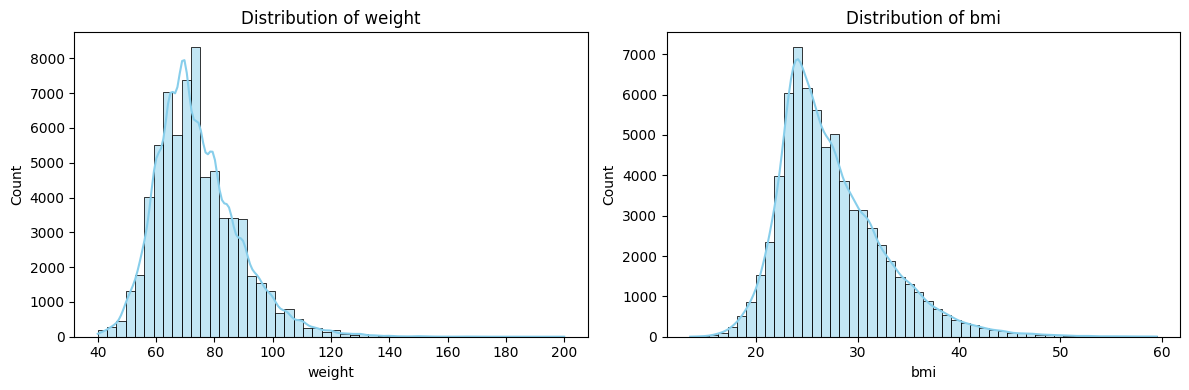

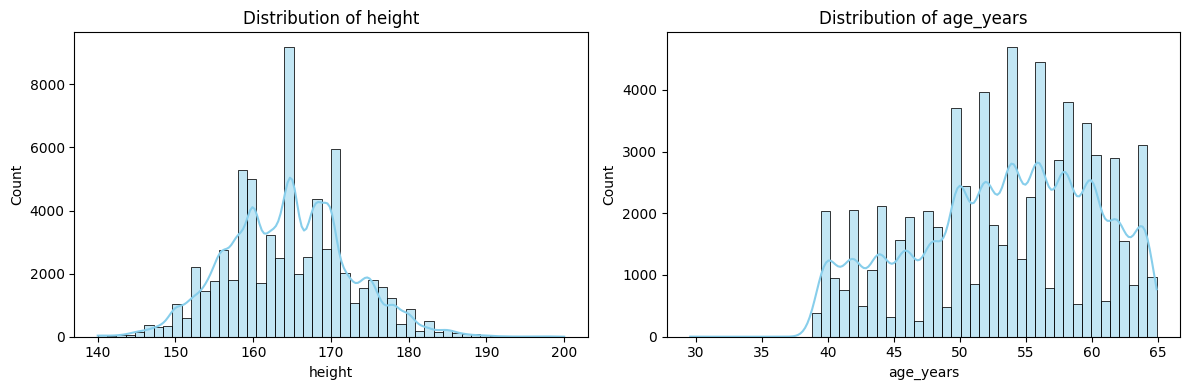

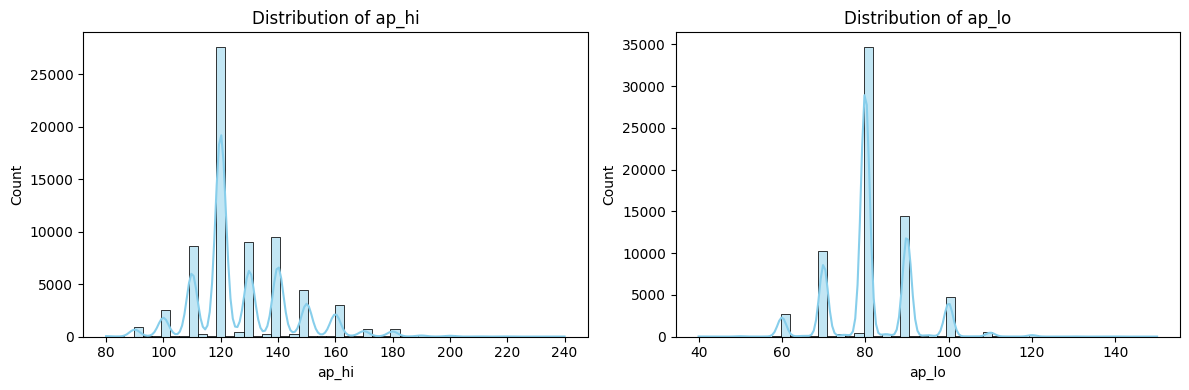

In [29]:
plot_hist(df_clean,["weight","bmi"])
plot_hist(df_clean,["height","age_years"])
plot_hist(df_clean,["ap_hi","ap_lo"])

#### 5.2 Distribution by gender

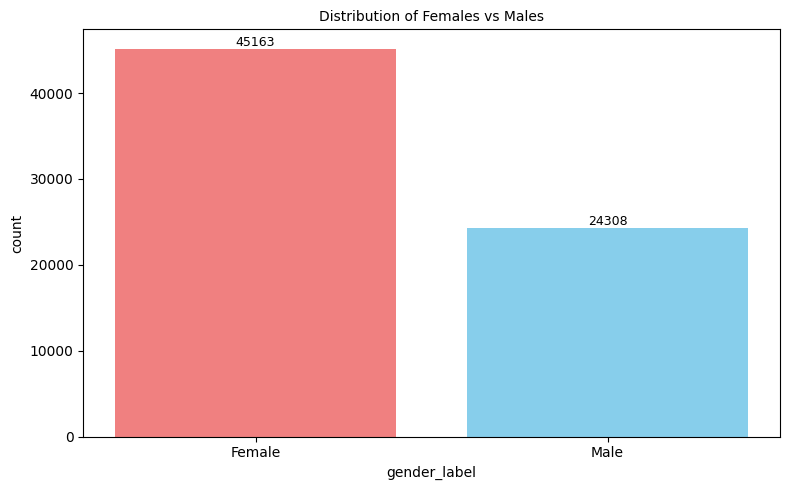

In [30]:
# Mapping gender values (1,2) to Male and Female
df_clean["gender_label"] = df["gender"].replace({1: "Female", 2: "Male"})
# Compute counts of individuals per gender
gender_counts = df_clean["gender_label"].value_counts().rename_axis("gender_label").reset_index(name="count")
# Plot
plot_bar(gender_counts,"gender_label","count",title ="Distribution of Females vs Males", color =["lightcoral","skyblue"])

#### Interpretation
**Note:** In the original dataset, gender is coded as:
- 1 = Female
- 2 = Male

I mapped these values to readable labels for analysis.

In this dataset : Females - 63-64% and Males - 36-37 %

#### 5.3 BMI category



I defined BMI bins using WHO standards:

- Underweight: < 18.5  
- Normal: 18.5–24.9  
- Overweight: 25–29.9  
- Obesity I: 30–34.9  
- Obesity II: 35–39.9  
- Obesity III: ≥ 40  

These bins are stored in a configuration block for easy reuse.

In [31]:
df_clean["bmi_bin"] = pd.cut(
    df_clean["bmi"],
    bins=config.BMI_BINS,
    labels=config.BMI_LABELS,
    right=False,           
    include_lowest=True
).astype("category").cat.set_categories(config.BMI_LABELS, ordered=True)


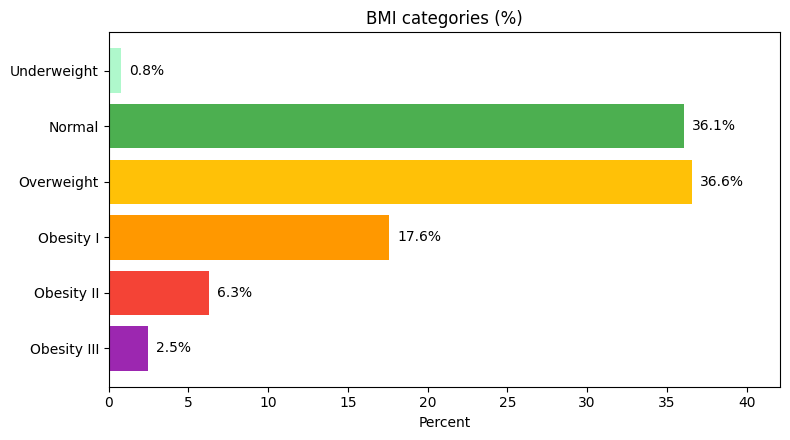

In [32]:
# Define bmi order and bmi colors for further analysis
bmi_counts = (
    df_clean["bmi_bin"]
    .value_counts()
    .rename_axis("bmi_bin")
    .reset_index(name="count")
    .sort_values("bmi_bin")
)

# plot
barh_percent(
    df_clean,
    "bmi_bin",
    order=config.BMI_LABELS[::-1],
    title="BMI categories (%)",
    palette=config.GRADIENT_COLORS[::-1],
)

#### Interpretation 
The BMI distribution in the dataset shows that:
- Normal: 36.1% of individuals fall within this BMI range 
- Overweight: 36.6% are classified as overweight (most common category) 
- Obesity range: 27.3% of the population 
     - Obesity I : 17.6% 
     - Obesity II: 6.3%
     - Obesity III : 2.5 % 
- Underweight: 0.8% of individuals

Overall, nearly 64% of the population have excess body weight, which suggests that this dataset represents a higher-risk clinical population rather than a general, healthier population.

#### 5.4 Blood pressure category

In [33]:
# create bp categories
df_clean["bp_category"]=df_clean.apply(categorize_bp,axis=1)

bp_counts = (
    df_clean["bp_category"]
    .value_counts()
    .rename_axis("bp_category")
    .reset_index(name="count")
)

bp_counts["bp_category"] = pd.Categorical(bp_counts["bp_category"], categories=config.BP_ORDER, ordered=True)
bp_counts = bp_counts.sort_values("bp_category")


In [40]:
# make bp_category -> categorical variable
df_clean["bp_category"] = pd.Categorical(
    df_clean["bp_category"],
    categories=config.BP_ORDER,
    ordered=True
)

In [41]:
bp_counts.head()

,bp_category,count
2,Normal,9520
3,Elevated,3098
0,Hypertension Stage 1,39764
1,Hypertension Stage 2,16929
4,Hypertensive Crisis,160


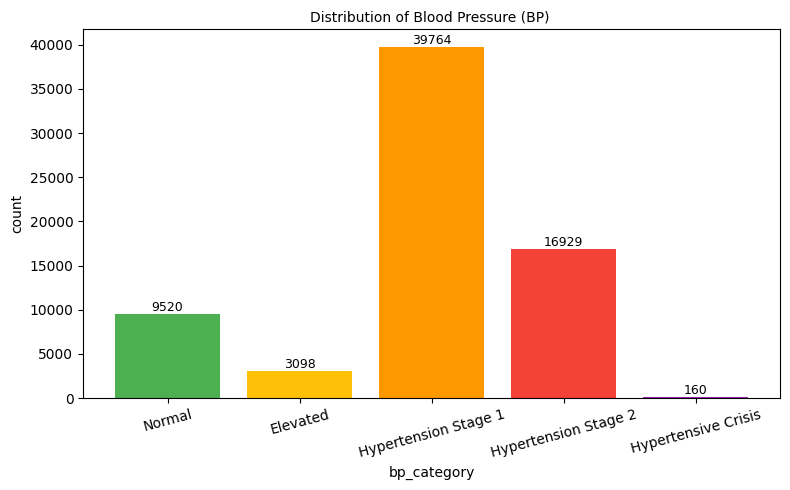

In [42]:
plot_bar(bp_counts,"bp_category","count",title ="Distribution of Blood Pressure (BP) ", color = config.GRADIENT_COLORS[1:],rotation = 15)

#### Interpretation

- Only 13.7% of the population has normal blood pressure.

- 4.5% are classified as elevated.

- A majority, 57.2%, fall into Hypertension Stage 1.

- An additional 24.4% fall into Hypertension Stage 2.

- 0.23% are in Hypertensive Crisis (very severe but rare).

In total, about 82% of the dataset is hypertensive (Stage 1, Stage 2, or Crisis).

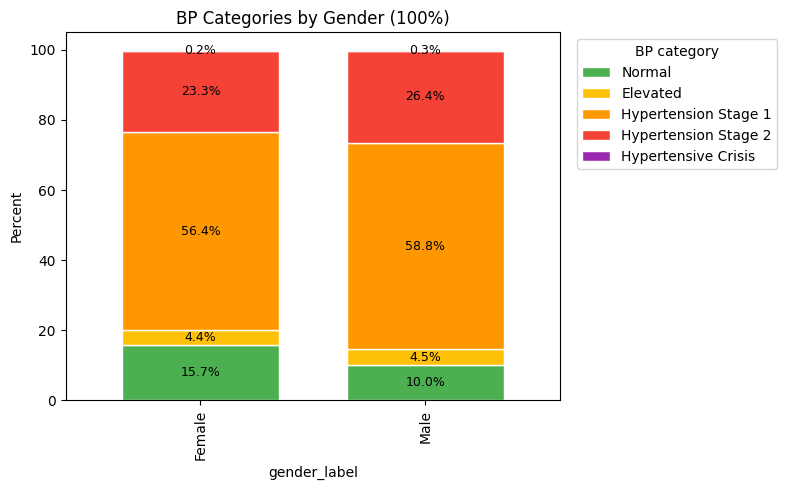

In [43]:
# Crosstab (percentage distribution of BP categories within each gender)
ct = pd.crosstab(df_clean["gender_label"],
                 pd.Categorical(df_clean["bp_category"], categories=config.BP_ORDER, ordered=True),
                 normalize="index") * 100

# plot 
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5), color=config.GRADIENT_COLORS[1:], edgecolor="white", width=0.7)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", fontsize=9, color="black")
plt.ylabel("Percent"); plt.title("BP Categories by Gender (100%)")
plt.legend(title="BP category", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

#### Interpretation

The stacked bar chart shows the percentage distribution of blood pressure categories within each gender.

- **Females** have a higher share of *Normal* blood pressure (**15.7%**) compared with males (**10.0%**).
- **Females** also show slightly lower rates of Hypertension Stage 1 (**56.4%**) and Stage 2 (**23.3%**), compared with males (**58.8%** and **26.4%**, respectively).

**Overall:**  
Men in this dataset show **higher prevalence of hypertension** than women, especially in more severe stages.


In [215]:
""" Labeling if person has CVD or not"""
df_clean["cardio_label"]=df_clean["cardio"].map({0:"No CVD",1:"CVD"})

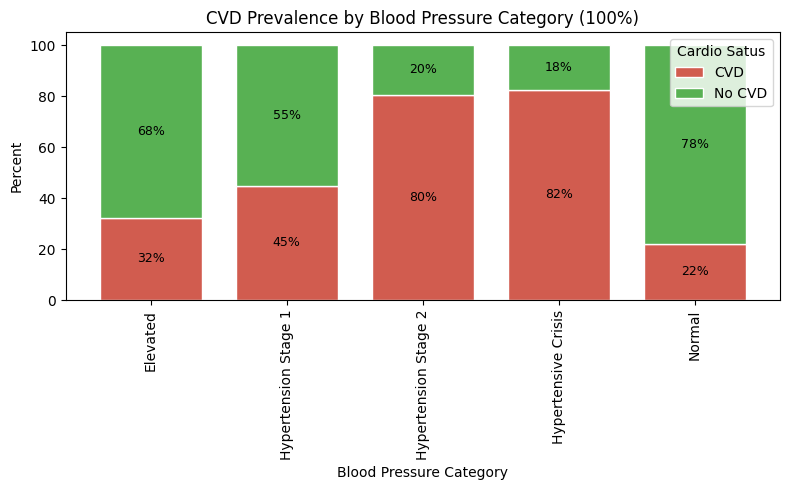

In [216]:
ct = pd.crosstab(df_clean["bp_category"], df_clean["cardio_label"], normalize="index") * 100
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5),
             color=["#D15C4F","#58B153"], edgecolor="white", width=0.75,)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=9, color="black")

plt.title("CVD Prevalence by Blood Pressure Category (100%)")
plt.ylabel("Percent"); plt.xlabel("Blood Pressure Category")
plt.legend(title="Cardio Satus"); plt.tight_layout(); plt.show()

#### Age

In [52]:
age_bins  = [18, 30, 40, 50, 60, 70, 80, 120]
age_names = ["18-29","30-39","40-49","50-59","60-69","70-79","80+"]
df_clean["age_bin"] = pd.cut(df_clean["age_years"], bins=age_bins, labels=age_names, right=False)

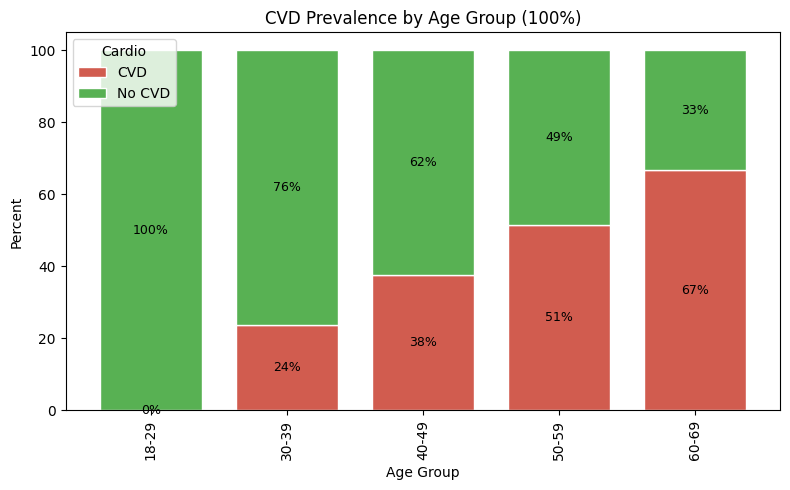

In [53]:
ct = pd.crosstab(df_clean["age_bin"], df_clean["cardio_label"], normalize="index") * 100
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5),
             color=["#D15C4F","#58B153"], edgecolor="white", width=0.75)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=9, color="black")

plt.title("CVD Prevalence by Age Group (100%)")
plt.ylabel("Percent"); plt.xlabel("Age Group")
plt.legend(title="Cardio"); plt.tight_layout(); plt.show()

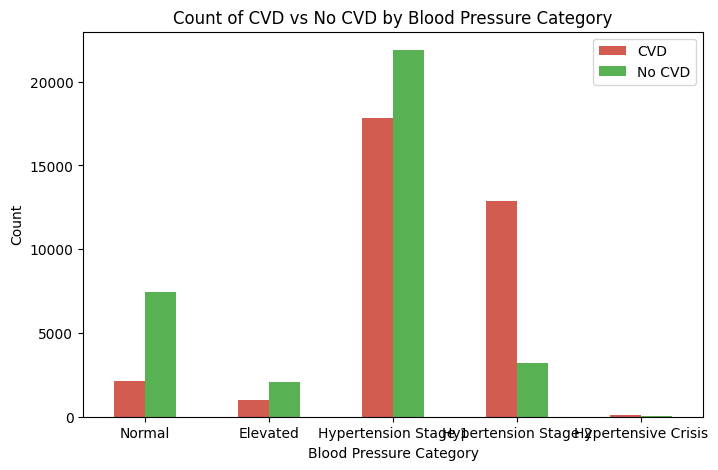

In [54]:
ct = pd.crosstab(df_clean["bp_category"], df_clean["cardio_label"])

ct.plot(kind="bar", figsize=(8,5), color=["#D15C4F", "#58B153"])

plt.title("Count of CVD vs No CVD by Blood Pressure Category")
plt.ylabel("Count")
plt.xlabel("Blood Pressure Category")
plt.xticks(rotation=0)
plt.legend(["CVD","No CVD"])
plt.show()

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='age_years', hue='cardio', data = df_clean, palette=["#58B153","#D15C4F"])

<Axes: xlabel='age_years', ylabel='count'>

In [ ]:
df_clean["gender_norm"]=df_clean["gender"]-1

<Axes: >

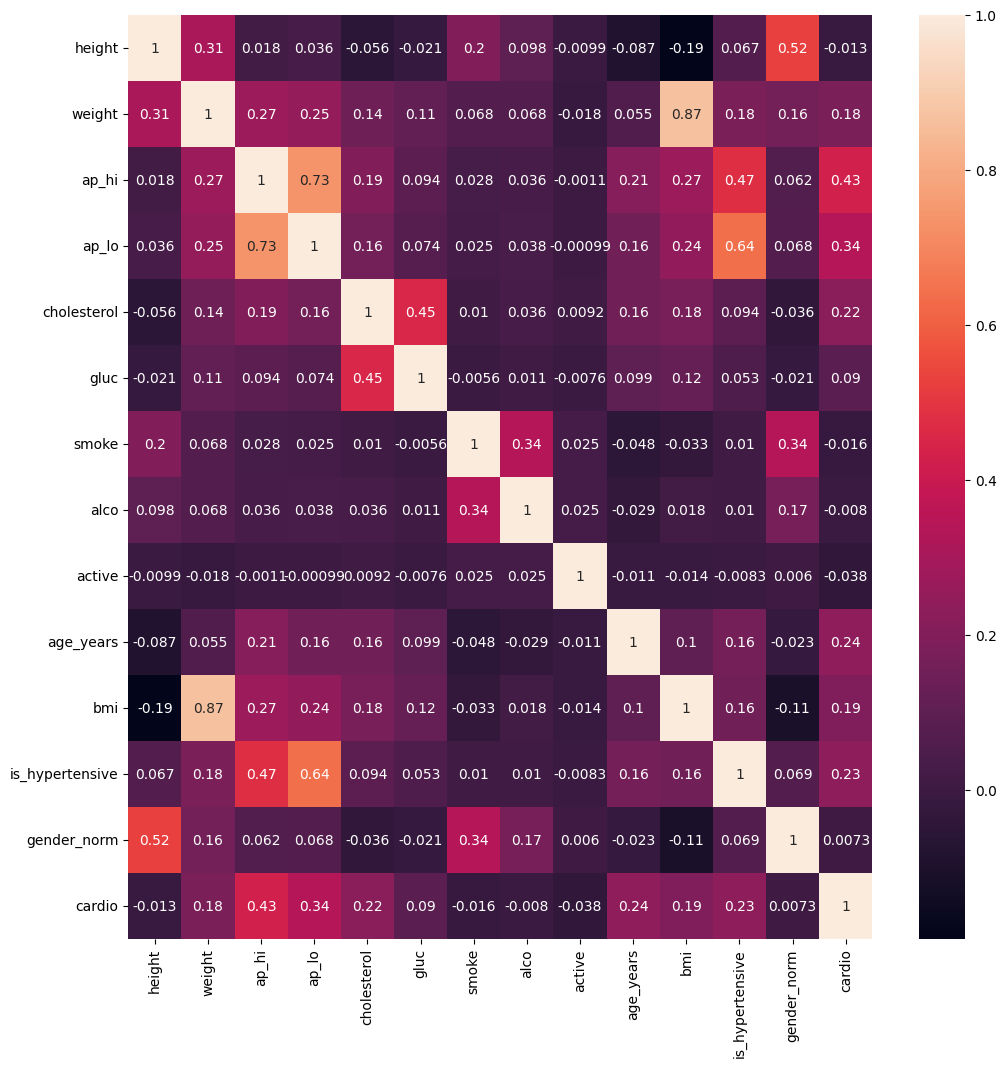

In [ ]:
df_clean_num = df_clean.drop(columns=["age", "gender","gender_label","bp_category","cardio_label","age_bin", "bmi_bin"])
cols = [col for col in df_clean_num.columns if col!= 'cardio'] + ['cardio']
df_clean_num = df_clean_num[cols]
plt.figure(figsize=(12, 12))
sns.heatmap(df_clean_num.corr(), annot=True)

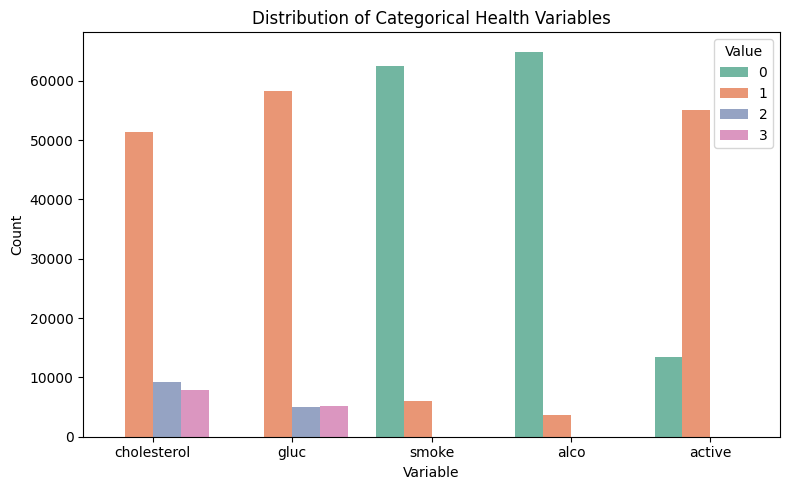

In [ ]:
# distribution of categorical values
df_categorical = df_clean.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
plt.figure(figsize=(8,5))
sns.countplot(
    x="variable", hue="value",
    data=pd.melt(df_categorical),
    palette="Set2"
)
plt.title("Distribution of Categorical Health Variables")
plt.xlabel("Variable")
plt.ylabel("Count")
plt.legend(title="Value")
plt.tight_layout()
plt.show()

Observations:
- Cholesterol and Glucose- a lot of people with normal values
- Smoke and alco - majority of people don;t smoke and don't drink
- Active - a lot of people exercise but there are some people which don;t exercise


In [ ]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,cardio,age_years,bmi,gender_label,bmi_bin,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm
0,18393,2,168,62.0,110,80,1,1,0,0,...,0,50,22.0,Female,Normal,Hypertension Stage 1,True,No CVD,50-59,1
1,20228,1,156,85.0,140,90,3,1,0,0,...,1,55,34.9,Male,Obesity I,Hypertension Stage 2,True,CVD,50-59,0
2,18857,1,165,64.0,130,70,3,1,0,0,...,1,52,23.5,Male,Normal,Hypertension Stage 1,True,CVD,50-59,0
3,17623,2,169,82.0,150,100,1,1,0,0,...,1,48,28.7,Female,Overweight,Hypertension Stage 2,True,CVD,40-49,1
4,17474,1,156,56.0,100,60,1,1,0,0,...,0,48,23.0,Male,Normal,Normal,False,No CVD,40-49,0


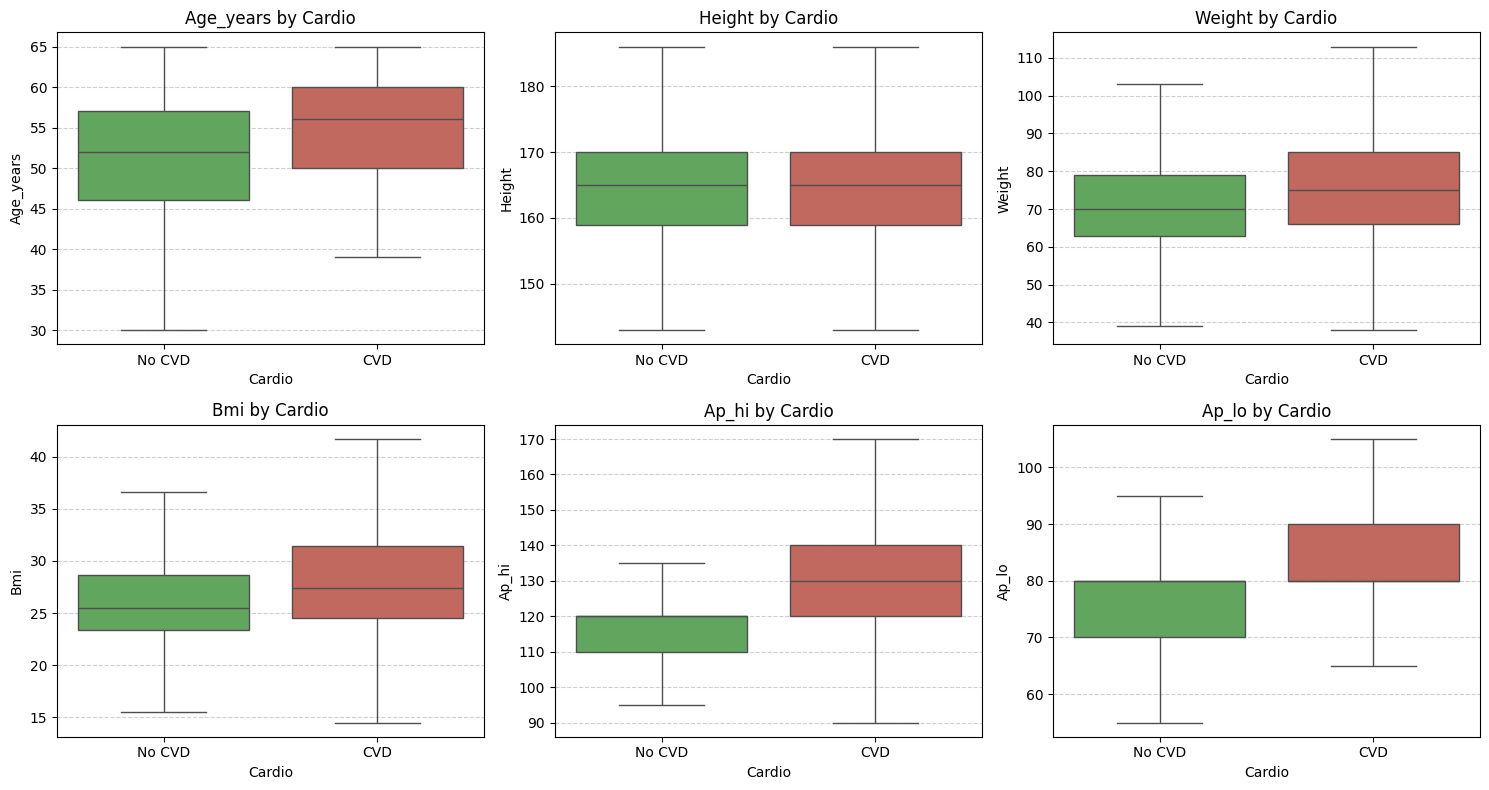

In [ ]:
num_variables = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']
plot_boxes(df_clean,num_variables,palette =["#58B153","#D15C4F"],n_cols = 3)

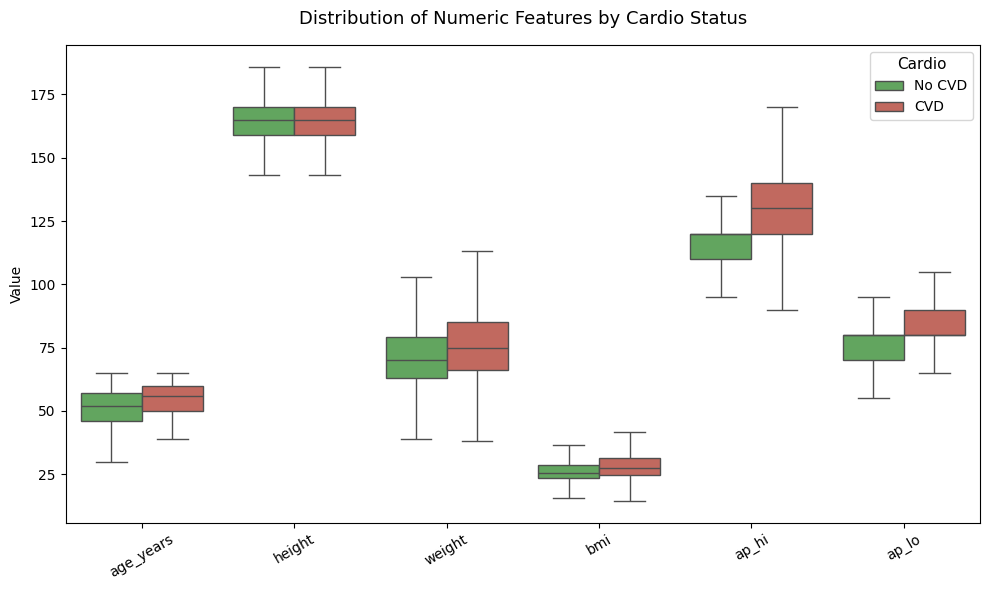

In [ ]:

num_vars = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']

#  Melt the dataset into long format
df_melted = df_clean.melt(
    id_vars='cardio',
    value_vars=num_vars,
    var_name='Feature',
    value_name='Value'
)


df_melted['cardio'] = df_melted['cardio'].map({0: 'No CVD', 1: 'CVD'})

# Create the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    x='Feature',
    y='Value',
    hue='cardio',
    data=df_melted,
    palette={'No CVD': "#58B153", 'CVD': "#D15C4F"},
    showfliers=False
)

#  Style the plot
plt.title('Distribution of Numeric Features by Cardio Status', fontsize=13, pad=15)
plt.xlabel('')
plt.ylabel('Value')
plt.xticks(rotation=30)
plt.legend(title='Cardio', title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()


## Statistics

Null Hypothesis: There is no significant difference in the distribution of the num variables between individuals with and without cardiovascular disease (CVD).

Alternative Hypothesis: There is a significant difference in the distribution of the num variables between individuals with and without CVD.

In [ ]:
# checking difference between distribution of num variables according to cardio_status
results = []

for col in num_variables:
    group0 = df_clean[df_clean['cardio'] == 0][col]
    group1 = df_clean[df_clean['cardio'] == 1][col]

    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')

    median0 = group0.median()
    median1 = group1.median()
    diff = median1 - median0

    results.append({
        'Variable': col.capitalize(),
        'Median (No CVD)': round(median0, 2),
        'Median (CVD)': round(median1, 2),
        'Median Diff': round(diff, 2),
        'U Statistic': round(stat, 2),
        'p-value': round(p, 5)
    })

summary_stat_df = pd.DataFrame(results)
summary_stat_df

,Variable,Median (No CVD),Median (CVD),Median Diff,U Statistic,p-value
0,Age_years,52.0,56.0,4.0,427475207.0,0.00000
1,Height,165.0,165.0,0.0,596636308.0,0.00085
2,Weight,70.0,75.0,5.0,465577370.5,0.00000
3,Bmi,25.5,27.4,1.9,453874573.0,0.00000
4,Ap_hi,120.0,130.0,10.0,292414912.0,0.00000
5,Ap_lo,80.0,80.0,0.0,363590138.0,0.00000


Reject Null Hypothesis. There is a significant differences between CVD and no CVD groups based on age,weight,BMI, ap_hi,ap_lo.

Null hypothesis: There is no association between cat variables and cardiovascular disease (CVD) status.

Alternative: There is an association between cat variables and cardiovascular disease (CVD) status.

### Lifestyle and health factors

In [ ]:
categorical_vars = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']
for var in categorical_vars:
    print(df[var].value_counts())

cholesterol
1    51420
2     9294
3     7875
Name: count, dtype: int64
gluc
1    58307
3     5222
2     5060
Name: count, dtype: int64
smoke
0    62547
1     6042
Name: count, dtype: int64
alco
0    64908
1     3681
Name: count, dtype: int64
active
1    55109
0    13480
Name: count, dtype: int64


In [ ]:
df_clean["cholesterol_label"]=df_clean["cholesterol"].map({1:"Normal", 2:"Above Normal", 3:"Well Above Normal"})
df_clean["glucose_label"]=df_clean["gluc"].map({1:"Normal", 2:"Above Normal", 3:"Well Above Normal"})
df_clean["smoke_label"]=df_clean["smoke"].map({0:"No", 1:"Yes"})
df_clean["alcohol_label"]=df_clean["alco"].map({0:"No", 1:"Yes"})
df_clean["active_label"]=df_clean["active"].map({0:"No", 1:"Yes"})

categorical_vars_labels =["cholesterol_label", "glucose_label", "smoke_label","alcohol_label","active_label" ]

In [ ]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm,cholesterol_label,glucose_label,smoke_label,alcohol_label,active_label
0,18393,2,168,62.0,110,80,1,1,0,0,...,Hypertension Stage 1,True,No CVD,50-59,1,Normal,Normal,No,No,Yes
1,20228,1,156,85.0,140,90,3,1,0,0,...,Hypertension Stage 2,True,CVD,50-59,0,Well Above Normal,Normal,No,No,Yes
2,18857,1,165,64.0,130,70,3,1,0,0,...,Hypertension Stage 1,True,CVD,50-59,0,Well Above Normal,Normal,No,No,No
3,17623,2,169,82.0,150,100,1,1,0,0,...,Hypertension Stage 2,True,CVD,40-49,1,Normal,Normal,No,No,Yes
4,17474,1,156,56.0,100,60,1,1,0,0,...,Normal,False,No CVD,40-49,0,Normal,Normal,No,No,No


In [ ]:
chol_gluc_order = STANDARD_BIO_INDICATOR_ORDER 

In [ ]:
for var in categorical_vars_labels:
    print(df_clean.groupby(var)["cardio_label"].value_counts())
    print("_________________________________________")

cholesterol_label  cardio_label
Above Normal       CVD              5545
                   No CVD           3749
Normal             No CVD          29014
                   CVD             22406
Well Above Normal  CVD              6007
                   No CVD           1868
Name: count, dtype: int64
_________________________________________
glucose_label      cardio_label
Above Normal       CVD              2976
                   No CVD           2084
Normal             No CVD          30555
                   CVD             27752
Well Above Normal  CVD              3230
                   No CVD           1992
Name: count, dtype: int64
_________________________________________
smoke_label  cardio_label
No           No CVD          31423
             CVD             31124
Yes          No CVD           3208
             CVD              2834
Name: count, dtype: int64
_________________________________________
alcohol_label  cardio_label
No             No CVD          32711
         

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cvd_subplots(df, categorical_vars_labels, target_col="cardio", ncols=2, rotation=0):
    n = len(categorical_vars_labels)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()
    
    chol_gluc_order = STANDARD_BIO_INDICATOR_ORDER 


    for i, var in enumerate(categorical_vars_labels):
        ax = axes[i]
        # Compute percentages of CVD (1) and No-CVD (0) by category
        ct = pd.crosstab(df[var], df[target_col], normalize="index") * 100
        
        if var in ["cholesterol_label", "glucose_label"]:
            ct = ct.reindex(chol_gluc_order)
        ct.plot(kind="bar", stacked=True, ax=ax, legend=False, color=["#58B153","#D15C4F"],rot =0)
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.0f%%', label_type='center',
                         fontsize=11, color='white', weight='bold')
        ax.set_title(f"{var[:-6].capitalize()}")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("")
        ax.tick_params(axis='x', labelrotation=0)
        ax.grid(False)

    # Remove empty axes if the grid is not full
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add one shared legend on top
    fig.legend(["No CVD", "CVD"], loc="upper center", ncol=2, frameon=False,fontsize =14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


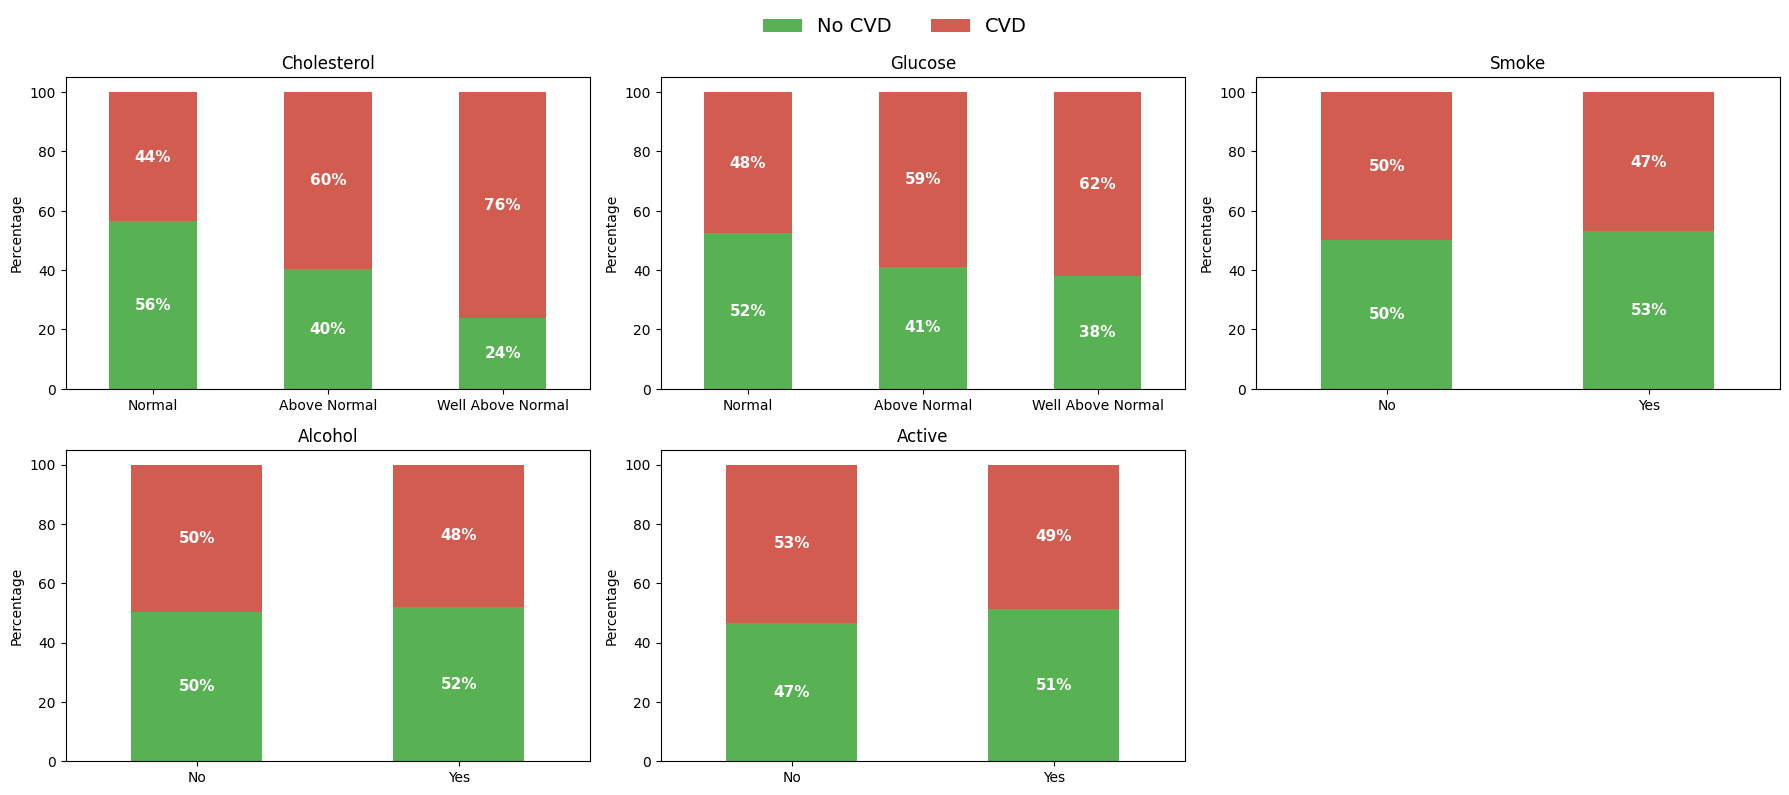

In [ ]:
plot_cvd_subplots(df_clean, categorical_vars_labels, target_col="cardio", ncols=3, rotation=30)

In [ ]:
# plot_subplots(df_clean,categorical_vars_labels,"gender_label",var_order=chol_gluc_order,target_order= ("Female","Male"),ncols=3,percent=True,colors =["lightcoral","skyblue"])


In [ ]:
var_order = {
    "cholesterol_label":STANDARD_BIO_INDICATOR_ORDER,
    "glucose_label": STANDARD_BIO_INDICATOR_ORDER,
    }

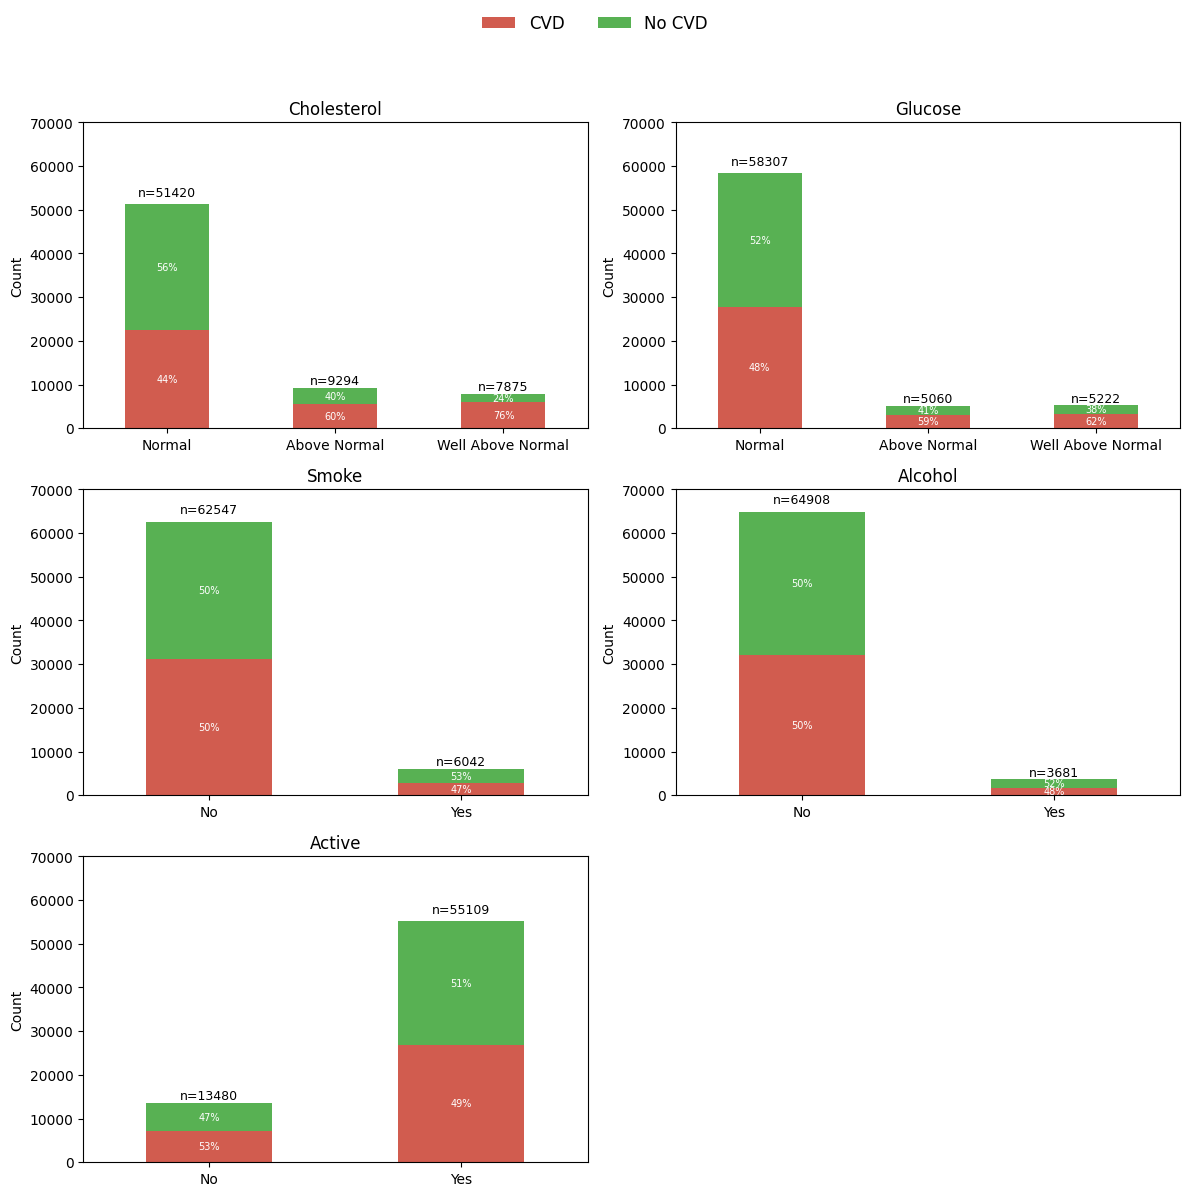

In [ ]:
plot_stacked_counts(df_clean,
                    categorical_vars_labels,
                    "cardio_label",
                    var_order=var_order,
                    ncols=2,
                    colors =["#D15C4F","#58B153"],
                    rotation=0,
                    show_percent_inside=True,
                    show_totals_above=True,
                    legend_loc="upper center",
                    ymax =70000)

Well above normal

~76% CVD

~24% No CVD

📌 As cholesterol increases, the proportion of individuals with CVD increases dramatically.

Well above normal

~62% CVD

~38% No CVD

📌 Again, higher glucose levels → higher % of people with CVD.

Individuals with above-normal or well-above-normal cholesterol or glucose levels have a substantially higher chance of having cardiovascular disease (CVD).

In [ ]:
pd.crosstab(df_clean["cardio_label"],
            df_clean["cholesterol_label"],
            normalize="index") * 100

cholesterol_label,Above Normal,Normal,Well Above Normal
cardio_label,,,
CVD,16.328995,65.981507,17.689499
No CVD,10.825561,83.780428,5.394011


✔ Interpretation (what this tells you)
1. People with CVD are much more likely to have high cholesterol

Above normal cholesterol:
16.3% (CVD) vs 10.8% (No CVD) → +50% difference

Well above normal cholesterol:
17.7% (CVD) vs 5.4% (No CVD) → over 3× higher

2. People without CVD are far more likely to have normal cholesterol

Normal cholesterol:
83.8% (No CVD) vs 66.0% (CVD)


Individuals diagnosed with CVD have significantly higher rates of elevated cholesterol. "Well above normal" cholesterol is especially over-represented among CVD patients (17.7% vs 5.4% in non-CVD). This supports cholesterol as a strong risk factor for cardiovascular disease.

In [33]:
plot_stacked_counts(df_clean,
                    categorical_vars_labels,
                    "gender_label",
                    var_order=var_order,
                    target_order= ("Female","Male"),
                    ncols=2,
                    colors =["lightcoral","skyblue"],
                    rotation=0,
                    show_percent_inside=True,
                    show_totals_above=True,
                    legend_loc="upper center",
                    ymax =70000)

NameError: name 'categorical_vars_labels' is not defined

Among smokers, a higher percentage are women (87%) compared to men (13%).
Among people who drink alcohol, a higher percentage are women (~64%).

Among individuals with above normal or well above normal cholesterol or glucose levels, a higher percentage are men than women.

In [ ]:
pd.crosstab(df_clean["gender_label"],
            df_clean["cholesterol_label"],
            normalize="index") * 100

cholesterol_label,Above Normal,Normal,Well Above Normal
gender_label,,,
Female,12.736618,77.067402,10.195980
Male,13.986296,73.843432,12.170272


Men have a slightly higher proportion of:

Above normal cholesterol (14% vs 12.7%)

Well above normal cholesterol (12.2% vs 10.2%)

Women have a higher proportion in the normal range (77% vs 73.8%).

📌 Correct interpretation

Men in this dataset are slightly more likely than women to have elevated (above or well above normal) cholesterol levels.

In [ ]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm,cholesterol_label,glucose_label,smoke_label,alcohol_label,active_label
0,18393,2,168,62.0,110,80,1,1,0,0,...,Hypertension Stage 1,True,No CVD,50-59,1,Normal,Normal,No,No,Yes
1,20228,1,156,85.0,140,90,3,1,0,0,...,Hypertension Stage 2,True,CVD,50-59,0,Well Above Normal,Normal,No,No,Yes
2,18857,1,165,64.0,130,70,3,1,0,0,...,Hypertension Stage 1,True,CVD,50-59,0,Well Above Normal,Normal,No,No,No
3,17623,2,169,82.0,150,100,1,1,0,0,...,Hypertension Stage 2,True,CVD,40-49,1,Normal,Normal,No,No,Yes
4,17474,1,156,56.0,100,60,1,1,0,0,...,Normal,False,No CVD,40-49,0,Normal,Normal,No,No,No


In [ ]:
pd.crosstab(df_clean["alcohol_label"],
            df_clean["cholesterol_label"],
            normalize="index") * 100

cholesterol_label,Above Normal,Normal,Well Above Normal
alcohol_label,,,
No,13.237197,75.414433,11.348370
Yes,19.070905,67.101331,13.827764


✔ People who drink alcohol have higher cholesterol levels than those who don’t.

Specifically:

Above Normal cholesterol

No alcohol: 13.2%

Yes alcohol: 19.1%
➡ Higher among alcohol drinkers

Well Above Normal cholesterol

No alcohol: 11.3%

Yes alcohol: 13.8%
➡ Also higher among alcohol drinkers

Normal cholesterol

No alcohol: 75.4%

Yes alcohol: 67.1%
➡ More non-drinkers have normal cholesterol

Individuals who drink alcohol show a higher proportion of both Above Normal and Well Above Normal cholesterol levels compared to non-drinkers, while non-drinkers are more likely to have normal cholesterol.

In [ ]:
#Association between cat_values and cardio_status


results2 = []

for col in categorical_vars:
    contingency = pd.crosstab(df_clean[col], df_clean['cardio'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    k, r = contingency.shape
    cramer_v = np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

    results2.append({
        'Variable': col,
        'Chi2': round(chi2, 2),
        'p-value': round(p, 5),
        'Cramér V': round(cramer_v, 3)
    })

pd.DataFrame(results2)


,Variable,Chi2,p-value,Cramér V
0,cholesterol,3365.39,0.00000,0.222
1,gluc,578.94,0.00000,0.092
2,smoke,17.86,0.00002,0.016
3,alco,4.26,0.03891,0.008
4,active,96.31,0.00000,0.037


Chi-square tests showed that cholesterol and glucose levels differ significantly between individuals with and without CVD (p < 0.001).
However, Cramér’s V indicates that only cholesterol exhibits a moderate practical association (V = 0.22), while glucose and lifestyle factors (smoking, alcohol, activity) show weak or negligible effects.

In [ ]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm,cholesterol_label,glucose_label,smoke_label,alcohol_label,active_label
0,18393,2,168,62.0,110,80,1,1,0,0,...,Hypertension Stage 1,True,No CVD,50-59,1,Normal,Normal,No,No,Yes
1,20228,1,156,85.0,140,90,3,1,0,0,...,Hypertension Stage 2,True,CVD,50-59,0,Well Above Normal,Normal,No,No,Yes
2,18857,1,165,64.0,130,70,3,1,0,0,...,Hypertension Stage 1,True,CVD,50-59,0,Well Above Normal,Normal,No,No,No
3,17623,2,169,82.0,150,100,1,1,0,0,...,Hypertension Stage 2,True,CVD,40-49,1,Normal,Normal,No,No,Yes
4,17474,1,156,56.0,100,60,1,1,0,0,...,Normal,False,No CVD,40-49,0,Normal,Normal,No,No,No


#### Stratification Matrix

In [ ]:
df_clean_summary3 = (
    df_clean
    .groupby(["age_bin", "bp_category"], observed=True)
    .agg(count=("cardio", "size"), cvd_rate=("cardio", "mean"))
    .reset_index()
)

df_clean_summary3.pivot(index="age_bin", columns="bp_category", values="cvd_rate")


bp_category,Normal,Elevated,Hypertension Stage 1,Hypertension Stage 2,Hypertensive Crisis
age_bin,,,,,
30-39,0.064000,0.172414,0.176768,0.720000,1.000000
40-49,0.143178,0.203905,0.324920,0.791170,0.758621
50-59,0.240643,0.332466,0.440138,0.793363,0.804878
60-69,0.427184,0.486043,0.612605,0.823842,0.852941


In [ ]:
df_clean_summary3["cvd_rate"] = pd.to_numeric(df_clean_summary3["cvd_rate"], errors="coerce")

In [ ]:
df_clean_final=df_clean.copy()

In [ ]:
high_bmi = ["Obesity I", "Obesity II", "Obesity III"]
high_bp  = ["Hypertension Stage 1", "Hypertension Stage 2"]

sub = df_clean[
    (df_clean["gender_label"] == "Female") &
    (df_clean["bmi_bin"].isin(high_bmi)) &
    (df_clean["bp_category"].isin(high_bp))
]

n = len(sub)
risk = sub["cardio"].mean() * 100   # % with CVD in this group

print(f"n = {n}")
print(f"CVD risk for women with high BMI and high BP = {risk:.1f}%")


n = 4344
CVD risk for women with high BMI and high BP = 67.2%


In [ ]:
high_bmi = ["Obesity I", "Obesity II", "Obesity III"]
high_bp  = ["Hypertension Stage 1", "Hypertension Stage 2"]

sub = df_clean[
    (df_clean["gender_label"] == "Male") &
    (df_clean["bmi_bin"].isin(high_bmi)) &
    (df_clean["bp_category"].isin(high_bp))
]

n = len(sub)
risk = sub["cardio"].mean() * 100   # % with CVD in this group

print(f"n = {n}")
print(f"CVD risk for men with high BMI and high BP = {risk:.1f}%")

n = 11627
CVD risk for men with high BMI and high BP = 65.5%


In [ ]:
# the group wih the highest risk for CVD among the dataset
risk_table = (
    df_clean
    .groupby(["gender_label", "bmi_bin", "bp_category"])
    .agg(
        n=("cardio", "size"),
        cvd_rate=("cardio", "mean")
    )
)

risk_table["cvd_rate"] = risk_table["cvd_rate"] * 100

# keep only groups with enough people (e.g. at least 50) to avoid tiny noisy groups
risk_table = risk_table.query("n >= 50")

# sort by highest CVD rate
risk_table.sort_values("cvd_rate", ascending=False).head(10)


/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_64677/243024028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["gender_label", "bmi_bin", "bp_category"])


n   cvd_rate
gender_label bmi_bin     bp_category                          
Female       Obesity II  Hypertension Stage 2   391  84.910486
Male         Obesity III Hypertension Stage 2   639  84.194053
             Obesity II  Hypertension Stage 2  1240  83.467742
Female       Overweight  Hypertension Stage 2  2578  81.730023
Male         Obesity I   Hypertension Stage 2  2621  80.923312
Female       Obesity I   Hypertension Stage 2  1360  80.735294
Male         Overweight  Hypertension Stage 2  3343  79.300030
Female       Obesity III Hypertension Stage 2   106  79.245283
             Normal      Hypertension Stage 2  1609  77.315103
Male         Normal      Hypertension Stage 2  2138  76.847521

One of the highest risk groups are women with obesity II and Hypertension Stage 2

The highest-risk groups in this dataset are individuals with both obesity and Hypertension Stage 2, with CVD rates around 80–85%.
For example, women with Obesity II and Stage 2 hypertension have a CVD prevalence of about 85% (n = 391), and similar high rates are seen in men with Obesity III and Stage 2 hypertension.

(obesity + Stage 2 BP = very high risk),

In [ ]:
pd.crosstab(df_clean["gender_label"],
            df_clean["bp_category"])

bp_category,Normal,Elevated,Hypertension Stage 1,Hypertension Stage 2,Hypertensive Crisis
gender_label,,,,,
Female,2426,1104,14277,6067,57
Male,7112,1993,25444,10019,90


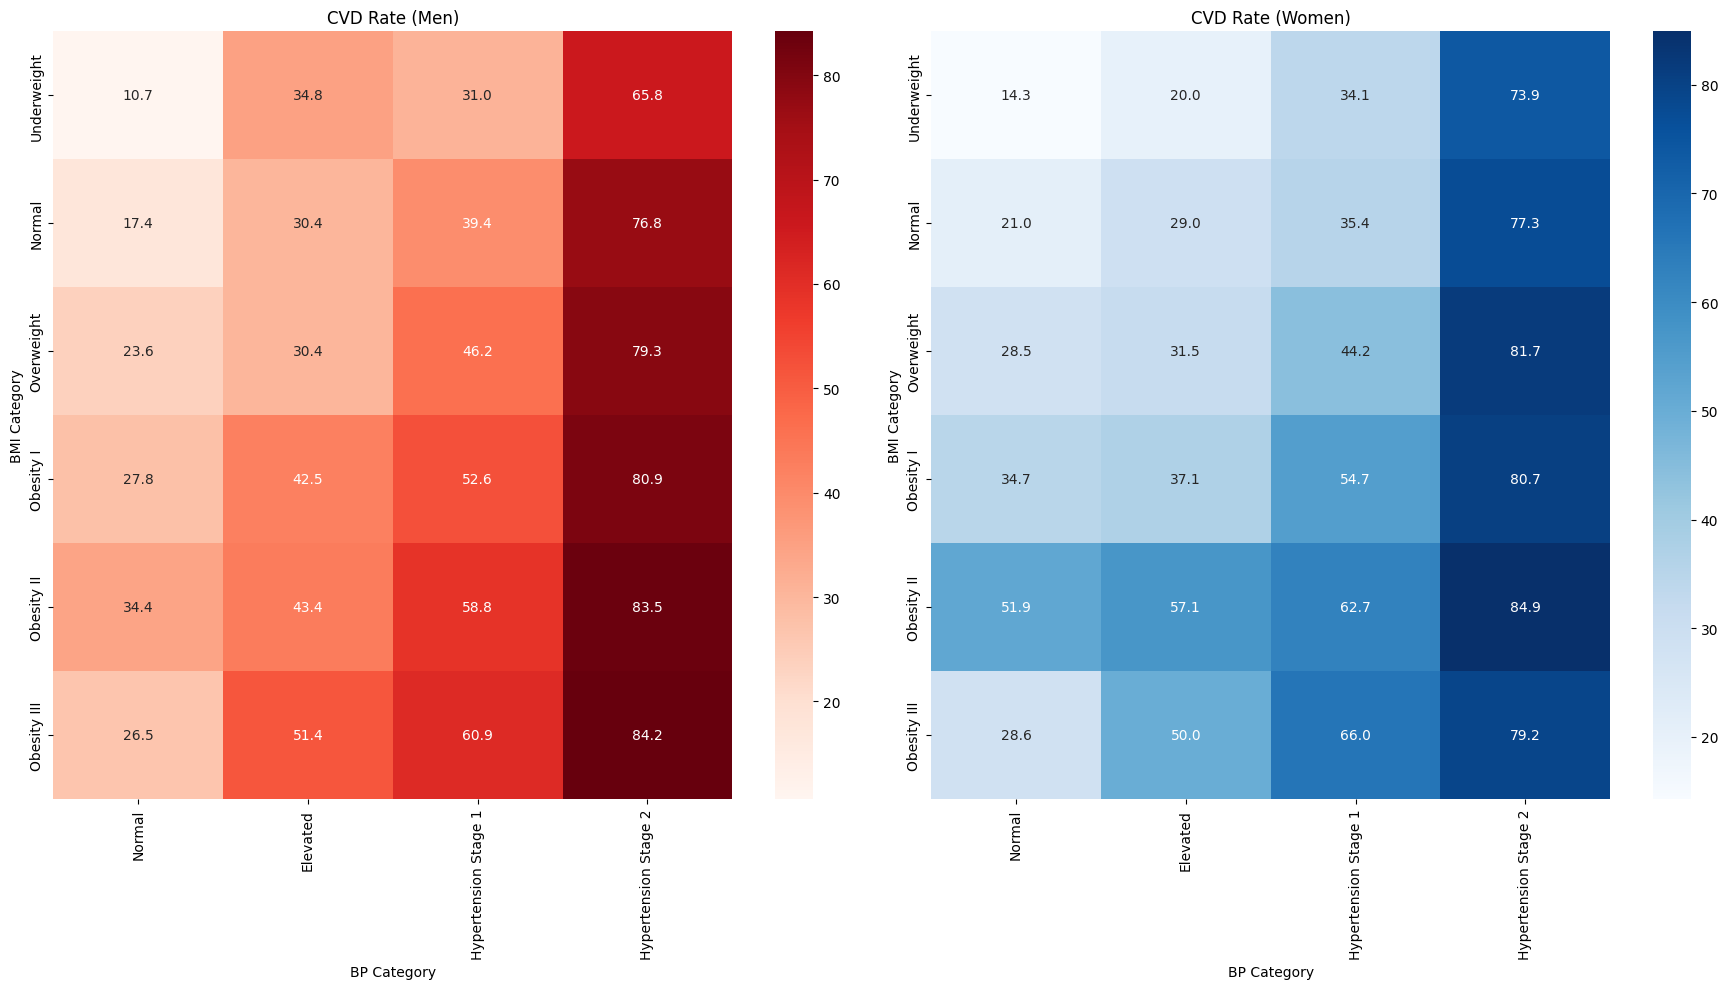

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

df_clean_no_hc = df_clean[df_clean["bp_category"] != "Hypertensive Crisis"].copy()
df_clean_no_hc["bp_category"] = (
    df_clean_no_hc["bp_category"]
    .cat.remove_unused_categories()
)
# male
df_male = df_clean_no_hc[df_clean_no_hc["gender_label"] == "Male"]
male_heatmap = plot_heatmap_table(df_male, ["bmi_bin","bp_category"], "cardio",
              "CVD Rate (Men)", "BP Category", "BMI Category", axes[0], cmap="Reds")

# female
df_female = df_clean_no_hc[df_clean_no_hc["gender_label"] == "Female"]
female_heatmap = plot_heatmap_table(df_female, ["bmi_bin","bp_category"], "cardio",
              "CVD Rate (Women)", "BP Category", "BMI Category", axes[1], cmap="Blues")

plt.tight_layout()
plt.show()

<Axes: xlabel='bp_category', ylabel='bmi_bin'>

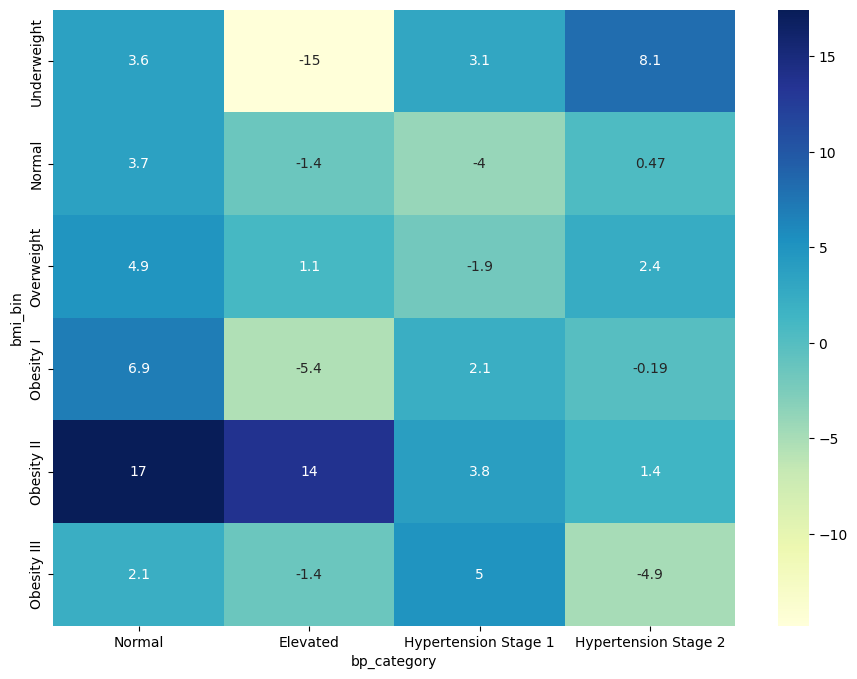

In [ ]:
sns.heatmap(female_heatmap - male_heatmap, annot=True, cmap='YlGnBu')

These differences might reflect a mix of real sex-related biology and sample bias/confounding.
With this EDA alone, we can’t separate the two.

When comparing men and women within the same BMI and BP categories, CVD risk in hypertensive groups (especially Obesity II with hypertension) appears similar between sexes.

However, among individuals with Obesity II but normal or slightly elevated blood pressure, women in this dataset show ~14–17 percentage points higher CVD prevalence than men.

This pattern could be influenced by biological and clinical differences (e.g., body-fat distribution, age/menopause effects, or delayed diagnosis in women), but it may also reflect confounding by age, cholesterol, diabetes and other risk factors, or sampling bias. 

Since our analysis does not adjust for these variables, we interpret this as an exploratory observation rather than proof of a causal biological difference.

In [ ]:
import pandas as pd

# choose the variables we want to adjust for
cols = [
    "cardio",        # target: 0/1 CVD
    "gender_label",  # "Male"/"Female"
    "bmi_bin",       # your BMI categories
    "bp_category",   # your BP categories
    "age_years",     # numeric age
    "cholesterol",   # 1 / 2 / 3
    "gluc",          # 1 / 2 / 3
    "smoke",         # 0/1
    "alco",          # 0/1
    "active"         # 0/1
]

df_reg = df_clean[cols].dropna().copy()



In [ ]:
import statsmodels.formula.api as smf

formula = """
cardio ~ C(gender_label)
        + C(bmi_bin)
        + C(bp_category)
        + age_years
        + C(cholesterol)
        + C(gluc)
        + smoke + alco + active
"""

logit_model = smf.logit(formula=formula, data=df_reg).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.581784
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68589
Model:                          Logit   Df Residuals:                    68570
Method:                           MLE   Df Model:                           18
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.1606
Time:                        13:24:46   Log-Likelihood:                -39904.
converged:                       True   LL-Null:                       -47539.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -4.5274   

In [ ]:
odds_ratios = np.exp(logit_model.params)
print(odds_ratios)

Intercept                                  0.010809
C(gender_label)[T.Male]                    0.933511
C(bmi_bin)[T.Normal]                       1.355889
C(bmi_bin)[T.Overweight]                   1.713876
C(bmi_bin)[T.Obesity I]                    2.041141
C(bmi_bin)[T.Obesity II]                   2.502538
C(bmi_bin)[T.Obesity III]                  2.575053
C(bp_category)[T.Elevated]                 1.492184
C(bp_category)[T.Hypertension Stage 1]     2.282535
C(bp_category)[T.Hypertension Stage 2]     9.951561
C(bp_category)[T.Hypertensive Crisis]     10.096059
C(cholesterol)[T.2]                        1.543158
C(cholesterol)[T.3]                        3.317401
C(gluc)[T.2]                               1.042934
C(gluc)[T.3]                               0.706911
age_years                                  1.059024
smoke                                      0.893473
alco                                       0.824954
active                                     0.800334
dtype: float

Men have about 7% lower odds of CVD than women,
after controlling for:

BMI category

BP category

age

cholesterol

glucose

smoke, alcohol, physical activity

So within this dataset:

For two people with the same age, BMI bin, BP category, cholesterol etc., the man has slightly lower predicted risk of CVD than the woman.

The effect is small compared to BMI, BP and age, but it’s statistically significant.

This actually fits your heatmap story pretty well:
in some cells (like Obesity II + Normal/Elevated BP), women show noticeably higher CVD % than men — and the regression confirms that, even after adjusting for the main risk factors, being female is associated with a bit more CVD in this data.

It doesn’t prove pure biology, but it shows the pattern isn’t only due to age/BP/BMI imbalance.

Odds ratios (vs reference groups):

C(bmi_bin)[T.Obesity II] → OR ≈ 2.50

Obesity II ≈ 2.5× higher odds of CVD vs Underweight (reference), keeping everything else fixed.

C(bp_category)[T.Hypertension Stage 2] → OR ≈ 9.95

Stage 2 hypertension ≈ 10× higher odds of CVD vs Normal BP.

Age: age_years coef = 0.0573 → OR ≈ 1.06 per year

Each extra year ≈ 6% higher odds; +10 years ≈ 1.06¹⁰ ≈ 1.8×.

Compare that to gender:

OR_male ≈ 0.93 → only a 7% difference.

So for your interpretation:

Sex differences exist, but in this dataset, blood pressure, BMI and age are much stronger predictors of CVD than gender itself.

“After adjusting for age, BMI, blood pressure category and other risk factors in a logistic regression model, sex remains a small but statistically significant predictor of CVD: men have about 7% lower odds of CVD than women with similar profiles in this dataset. This supports the idea that sex-related factors (biological and/or clinical) may contribute to the higher CVD rates observed in women in some BMI/BP groups in our heatmaps, although we cannot separate biology from residual confounding or data bias.”

Final conclusion:


The raw heatmap showed that women with Obesity II and normal/elevated BP had 14–17 percentage points higher CVD rates than men.
After adjusting for age, BMI category, BP category, cholesterol, glucose, smoking, alcohol consumption and physical activity, the logistic regression still finds a small but significant sex effect in the same direction: men have ~7% lower odds of CVD than comparable women.
This suggests that the observed difference is not solely due to confounding by age or risk factors. However, the model cannot determine whether this residual difference is biological (e.g., fat distribution, menopause), behavioral (e.g., delayed diagnosis in women), or due to measurement or sampling bias. Therefore, these results should be interpreted as associative, not causal.

Sex differences in CVD risk across BMI and blood pressure categories

When comparing men and women within the same BMI and blood pressure categories, we observe that CVD rates are very similar for individuals with Obesity II and hypertension. However, among individuals with Obesity II but normal or elevated blood pressure, women in this dataset show approximately 14–17 percentage points higher CVD prevalence than men.

To examine whether this pattern is purely due to age or other confounding factors, we fitted a multivariable logistic regression adjusting for age, BMI category, BP category, cholesterol, glucose, smoking, alcohol use and physical activity. After adjustment, sex remains a small but statistically significant predictor of CVD: men have roughly 7% lower odds of CVD than women with comparable profiles (OR = 0.93, p < 0.001).

This suggests that the difference observed in the heatmap is not entirely explained by age or other measured risk factors. Nonetheless, the model cannot determine whether the remaining gap is due to biological differences (e.g., fat distribution, hormonal changes), clinical patterns (e.g., underdiagnosis or later presentation in women), or dataset bias. Therefore, these results should be interpreted as associative rather than causal, but they highlight an interesting sex-specific pattern worth further investigation.

### References literature

“Previous research shows that while the overall association between BMI and CHD is similar in men vs women, sex-specific differences emerge when considering blood pressure and obesity. For example, women appear to incur cardiovascular risk at lower systolic BP thresholds than men (Regitz-Zagrosek 2023). In light of our finding that women with Obesity II and normal/elevated BP have 14–17 percentage points higher CVD prevalence than men, the literature provides plausible biological and clinical mechanisms (e.g., lower BP thresholds, later detection) but does not provide exact estimates for this specific subgroup.”

Then in a footnote or reference list include:

Regensteiner JG, et al. Sex Differences in Cardiovascular Consequences of Obesity, Hypertension, and Diabetes. 2022.

Betai D, et al. Gender Disparities in Cardiovascular Disease and Their Underlying Mechanisms. 2024.

Regitz-Zagrosek V, Gebhard C. Gender medicine: effects of sex and gender on cardiovascular disease manifestation and outcomes. Nature Reviews Cardiology. 2023.

## Feature engineering

## 5. Feature Engineering

In this section I create additional features that may help the model:

- **BMI** and **BMI categories** (Underweight, Normal, Overweight, Obesity I–III)
- **Blood pressure stages** (Normal, Elevated, Hypertension I–II, Crisis)
- **Pulse pressure** (ap_hi - ap_lo)
- **Age × BP stage** interaction
- **Metabolic syndrome-like indicator** combining BMI, BP, cholesterol, and glucose


In [ ]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,bp_category,is_hypertensive,cardio_label,age_bin,gender_norm,cholesterol_label,glucose_label,smoke_label,alcohol_label,active_label
0,18393,2,168,62.0,110,80,1,1,0,0,...,Hypertension Stage 1,True,No CVD,50-59,1,Normal,Normal,No,No,Yes
1,20228,1,156,85.0,140,90,3,1,0,0,...,Hypertension Stage 2,True,CVD,50-59,0,Well Above Normal,Normal,No,No,Yes
2,18857,1,165,64.0,130,70,3,1,0,0,...,Hypertension Stage 1,True,CVD,50-59,0,Well Above Normal,Normal,No,No,No
3,17623,2,169,82.0,150,100,1,1,0,0,...,Hypertension Stage 2,True,CVD,40-49,1,Normal,Normal,No,No,Yes
4,17474,1,156,56.0,100,60,1,1,0,0,...,Normal,False,No CVD,40-49,0,Normal,Normal,No,No,No


#### Metabolic Syndrome

In [ ]:
bp_stage_map = {
    "Normal": 0,
    "Elevated": 1,
    "Hypertension Stage 1": 2,
    "Hypertension Stage 2": 3,
    "Hypertensive Crisis": 4
}

In [ ]:
df_clean["bp_stage_num"] = df_clean["bp_category"].map(bp_stage_map)

In [ ]:
(
    df_clean[["bp_category", "bp_stage_num"]]
    .value_counts()
    .reset_index(name ="count")
    .sort_values("bp_stage_num")
    .set_index("bp_category")
)

,bp_stage_num,count
bp_category,,
Normal,0,9538
Elevated,1,3097
Hypertension Stage 1,2,39721
Hypertension Stage 2,3,16086
Hypertensive Crisis,4,147


In [ ]:
df_clean["metabolic_syndrome_like"] = (
    (df_clean["bp_stage_num"] >= 2).astype(int) +   # Hypertension Stage 1+
    (df_clean["bmi"] >= 30).astype(int) +           # Obesity
    (df_clean["cholesterol"] >= 2).astype(int) +    # High cholesterol
    (df_clean["gluc"] >= 2).astype(int)             # High glucose
) >= 3

df_clean["metabolic_syndrome_like"] = df_clean["metabolic_syndrome_like"].astype(int)


In [ ]:
cvd_rate_by_metabolic = (
    df_clean
    .groupby("metabolic_syndrome_like")["cardio"]
    .mean() * 100
 
)

cvd_rate_by_metabolic

metabolic_syndrome_like
0    45.601560
1    70.773854
Name: cardio, dtype: float64

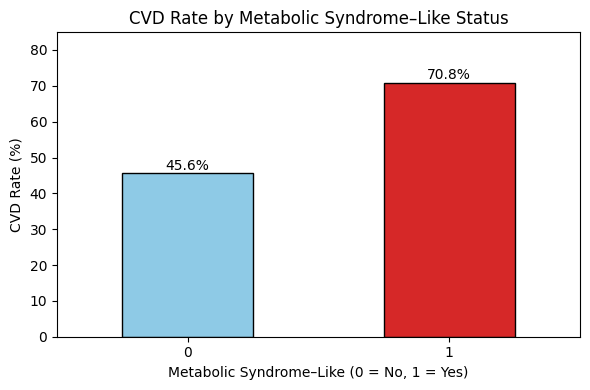

In [ ]:
plt.figure(figsize=(6,4))

cvd_rate_by_metabolic.plot(
    kind="bar",
    color=["#8ecae6", "#d62828"],
    edgecolor="black"
)

plt.title("CVD Rate by Metabolic Syndrome–Like Status")
plt.xlabel("Metabolic Syndrome–Like (0 = No, 1 = Yes)")
plt.ylabel("CVD Rate (%)")

plt.xticks(rotation=0)
plt.ylim(0, cvd_rate_by_metabolic.max() * 1.2)

# Add labels on top of bars
for i, rate in enumerate(cvd_rate_by_metabolic):
    plt.text(i, rate + 1, f"{rate:.1f}%", ha="center")

plt.tight_layout()
plt.show()


#### Obesity new categories

In [ ]:
df_clean_bmi = df_clean.copy()
df_clean_bmi["bmi_int"] =df_clean_bmi['bmi'].astype(int)
cvd_per_bmi = df_clean_bmi.groupby(["gender_label","bmi_int"],observed=True )["cardio"].mean().unstack()
cvd_per_bmi.isnull().any()
cvd_per_bmi

bmi_int,12,13,14,15,16,17,18,19,20,21,...,50,51,52,53,54,55,56,57,58,59
gender_label,,,,,,,,,,,,,,,,,,,,,
Female,NaN,1.0,0.333333,0.222222,0.192308,0.337500,0.281768,0.304225,0.332248,0.370062,...,0.75,1.000000,NaN,1.0,0.333333,0.500,1.000000,0.0,1.000000,1.0
Male,0.5,0.0,0.363636,0.350000,0.237500,0.206452,0.258278,0.256684,0.314501,0.356778,...,0.80,0.785714,0.708333,0.8,1.000000,0.625,0.714286,0.4,0.714286,1.0


In [ ]:
# removing bmi < 14 because 0 to 1 indviduals per group only
# fill NAS using forward fill method
clean_cvd_per_bmi = cvd_per_bmi.iloc[:, 2:].T.ffill().copy()

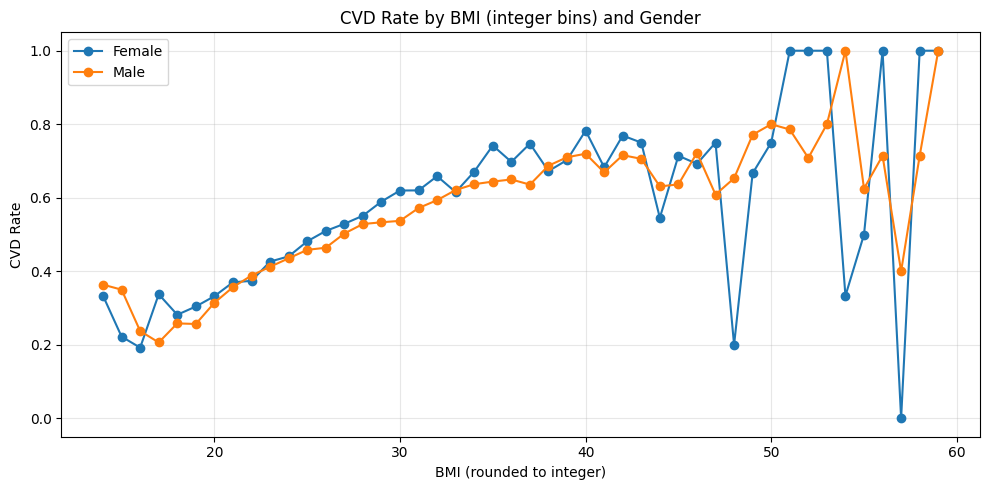

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for gender in clean_cvd_per_bmi.columns:
    plt.plot(
        clean_cvd_per_bmi.index, 
        clean_cvd_per_bmi[gender], 
        marker='o', 
        label=gender
    )

plt.title("CVD Rate by BMI (integer bins) and Gender")
plt.xlabel("BMI (rounded to integer)")
plt.ylabel("CVD Rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 4-BMI rolling mean, centered
cvd_roll = clean_cvd_per_bmi.rolling(
    window=4, center=True, min_periods=1
).mean()

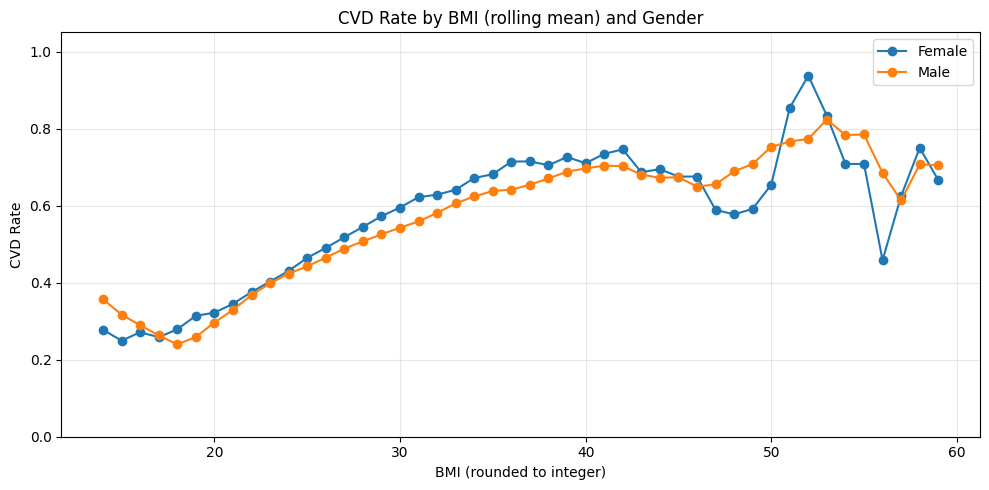

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for gender in cvd_roll.columns:
    plt.plot(
        cvd_roll.index,
        cvd_roll[gender],
        marker="o",
        label=gender
    )

plt.title("CVD Rate by BMI (rolling mean) and Gender")
plt.xlabel("BMI (rounded to integer)")
plt.ylim(0, 1.05)
plt.ylabel("CVD Rate")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Models
### 6.4 Interpretation

- The model achieves an accuracy of XX% and AUC of YY%.
- The recall indicates that the model detects ZZ% of patients with CVD.
- This is acceptable for a baseline medical risk model but could be improved with:
  - more features (e.g. lab tests, medications)
  - non-linear models (e.g. Random Forest, XGBoost)


# Conclusions& Next Steps

## 7. Conclusion & Next Steps

**Key findings:**
- Higher BMI and blood pressure stages are strongly associated with CVD.
- Cholesterol and glucose levels above normal increase the risk.
- Lifestyle factors (smoking, alcohol, physical activity) also play a role but are less dominant in this dataset.

**Limitations:**
- Cross-sectional dataset (no time dimension).
- Some variables are coarse (e.g. cholesterol level 1/2/3 only).
- No information on medications or family history.

**Future work:**
- Try tree-based models and compare performance.
- Use calibration curves to check probability estimates.
- Explore interaction effects between features more deeply.
